In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )

Found 16011 files belonging to 10 classes.


In [3]:
class_names = dataset.class_names
class_names


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [4]:
len(dataset)


501

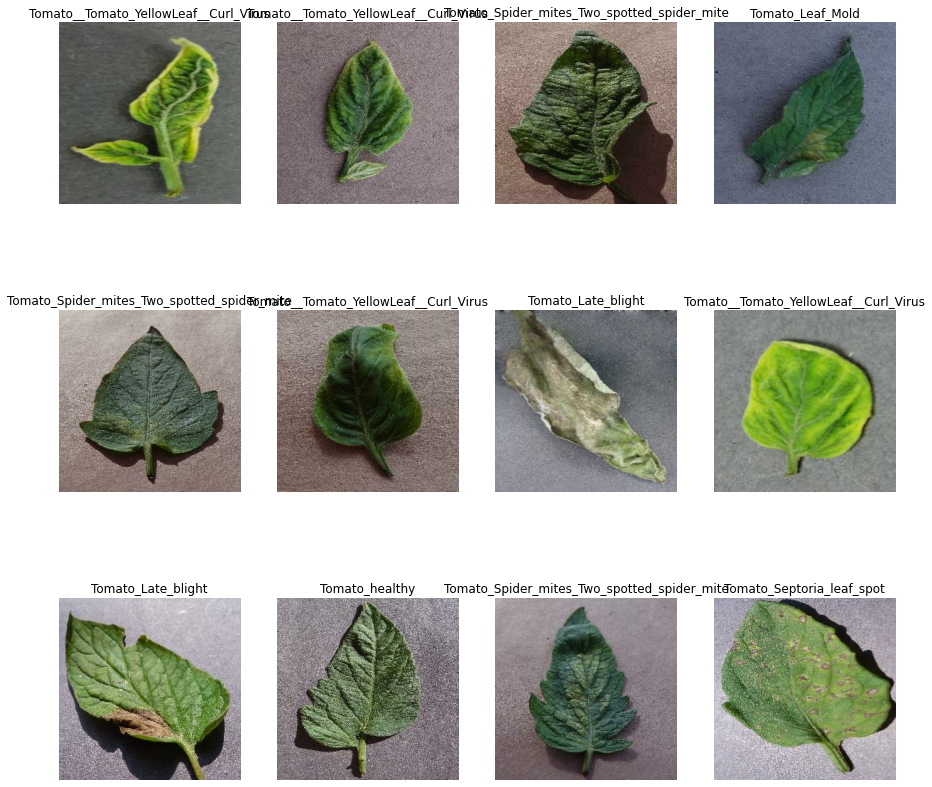

In [5]:
plt.figure(figsize = (15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split = 0.1,val_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,test_ds,val_ds


In [7]:
train_ds , test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

400

In [9]:
len(test_ds)

51

In [10]:
len(val_ds)

50

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(256,256),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (32,256,256,3)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds)

Epoch 1/50
400/400 [==============================] - 139s 347ms/step - loss: 1.1120 - accuracy: 0.6057 - val_loss: 1.1653 - val_accuracy: 0.6320
Epoch 2/50
400/400 [==============================] - 138s 346ms/step - loss: 0.5872 - accuracy: 0.7907 - val_loss: 0.6305 - val_accuracy: 0.8002
Epoch 3/50
400/400 [==============================] - 130s 326ms/step - loss: 0.4349 - accuracy: 0.8491 - val_loss: 0.7584 - val_accuracy: 0.7583
Epoch 4/50
400/400 [==============================] - 142s 354ms/step - loss: 0.3521 - accuracy: 0.8779 - val_loss: 0.6445 - val_accuracy: 0.8040
Epoch 5/50
400/400 [==============================] - 140s 351ms/step - loss: 0.3061 - accuracy: 0.8926 - val_loss: 0.9677 - val_accuracy: 0.7774
Epoch 6/50
400/400 [==============================] - 145s 362ms/step - loss: 0.2718 - accuracy: 0.9028 - val_loss: 0.5032 - val_accuracy: 0.8516
Epoch 7/50
400/400 [==============================] - 141s 353ms/step - loss: 0.2287 - accuracy: 0.9188 - val_loss: 0.3700 -

In [18]:
scores = model.evaluate(test_ds)

400/400 [==============================] - 49s 123ms/step - loss: 0.1540 - accuracy: 0.9597


In [19]:
scores

[0.15396736562252045, 0.9596874713897705]

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

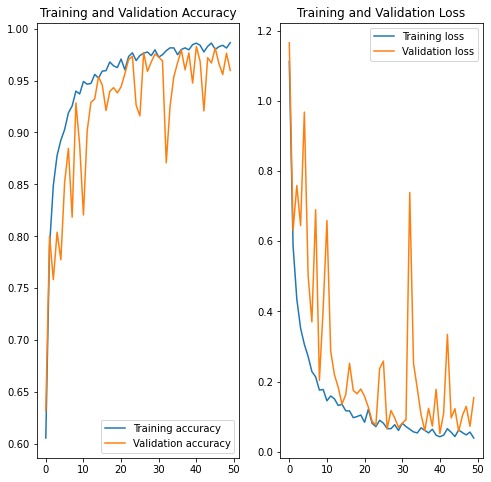

In [23]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')


First Image to Predict:
Actual Label: Tomato_healthy
Predicted Label: Tomato_healthy


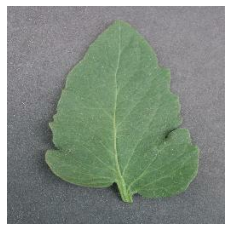

In [24]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to Predict:")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

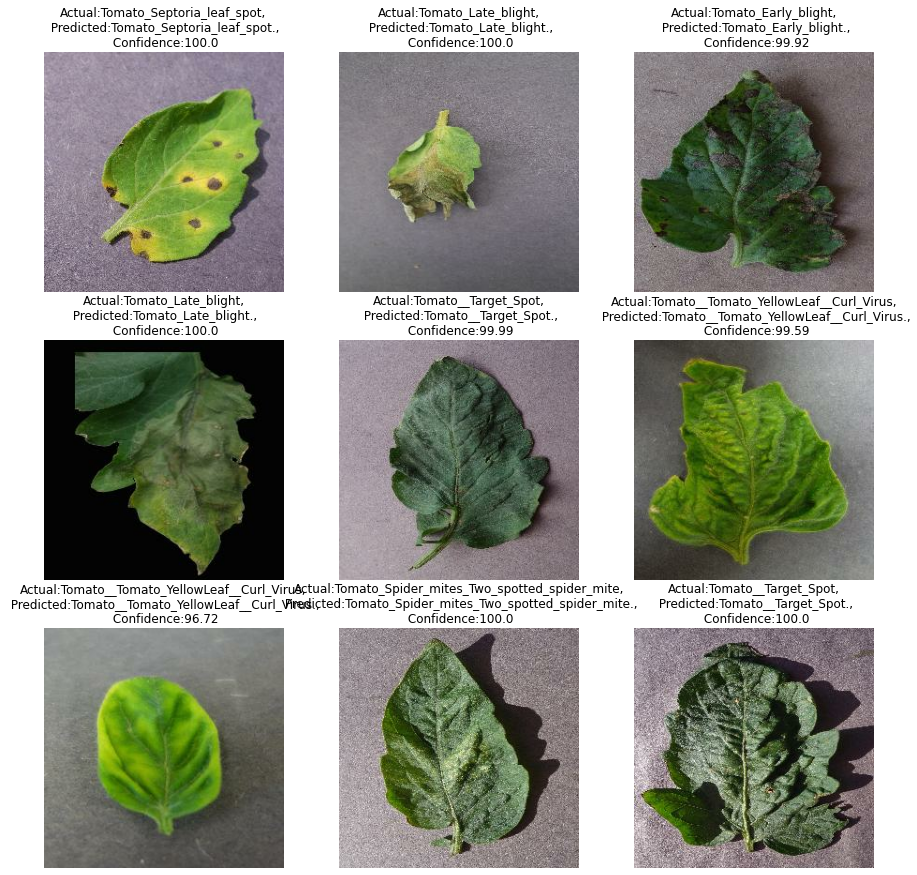

In [26]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.,\n Confidence:{confidence}")
        
        plt.axis("off")

In [27]:
import os
model_version =max([int(i) for i in os.listdir("/Tomato/models/")+[0]])+1 
model.save(f"/Tomato/models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Tomato/models/2\assets
